Добрый день.
Курсовой проект будет поделен на части согласно последовательности шагов курсового проекта.

In [324]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("default")

In [325]:
matplotlib.rcParams.update({'font.size': 14})

In [326]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# Предобработка данных

In [327]:
dataset_train = 'train.csv'
dataset_test = 'test.csv'

df_train = pd.read_csv(dataset_train)
df_test = pd.read_csv(dataset_test)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [328]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

В результатах видим, что у нас есть три признака (Ecology_2, Ecology_3, Shops_2) с типом object и их необходимо привести к другому виду.

## Приведение типов данных

In [329]:
df_train['Ecology_2_bin'] = df_train['Ecology_2'].replace({'A':0, 'B':1})
df_train['Ecology_3_bin'] = df_train['Ecology_3'].replace({'A':0, 'B':1})
df_train['Shops_2_bin'] = df_train['Shops_2'].replace({'A':0, 'B':1})
df_train.drop(['Ecology_2' , 'Ecology_3', 'Shops_2'], axis=1, inplace=True)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063,1,1,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524,1,1,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217,1,1,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644,1,1,1


In [330]:
df_train = df_train[df_train.columns[1:]]
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730,1,1,1
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063,1,1,1
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524,1,1,1
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217,1,1,1
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644,1,1,1


## Обзор переменных

In [331]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


In [332]:
len(df_train) - df_train.count()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Price               0
Ecology_2_bin       0
Ecology_3_bin       0
Shops_2_bin         0
dtype: int64

## Обработка пропусков

#### LifeSquare

Text(0.5, 0, 'LifeSquare')

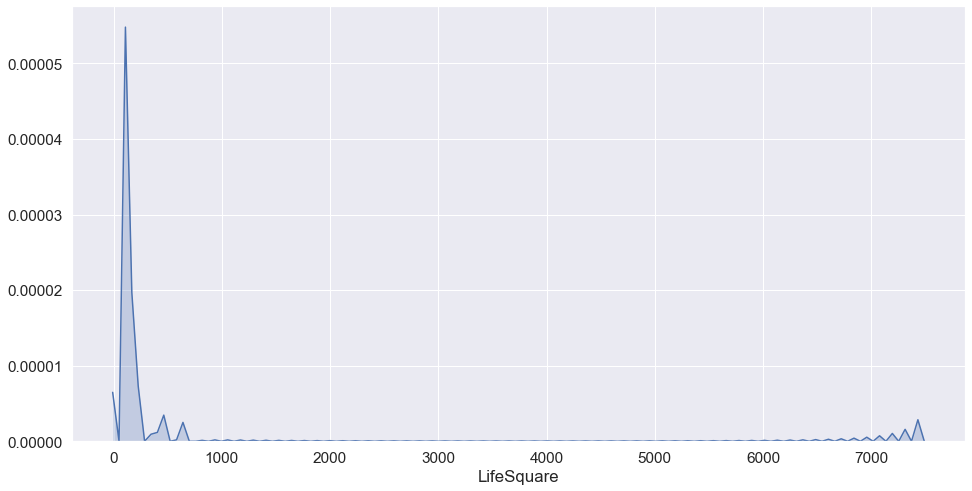

In [333]:
plt.figure(figsize = (16, 8))

sns.kdeplot(df_train['LifeSquare'], shade=True, legend=False)
plt.xlabel('LifeSquare')

Учитывая как на графике отражается распределение по значениям переменной, я не вижу причин не взять медиану. Также нельзя не заметить, что возможно в есть выбросы в записях со значением близким к максимальным.

In [334]:
df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = df_train['LifeSquare'].median()

 #### Healthcare_1

Text(0.5, 0, 'Healthcare_1')

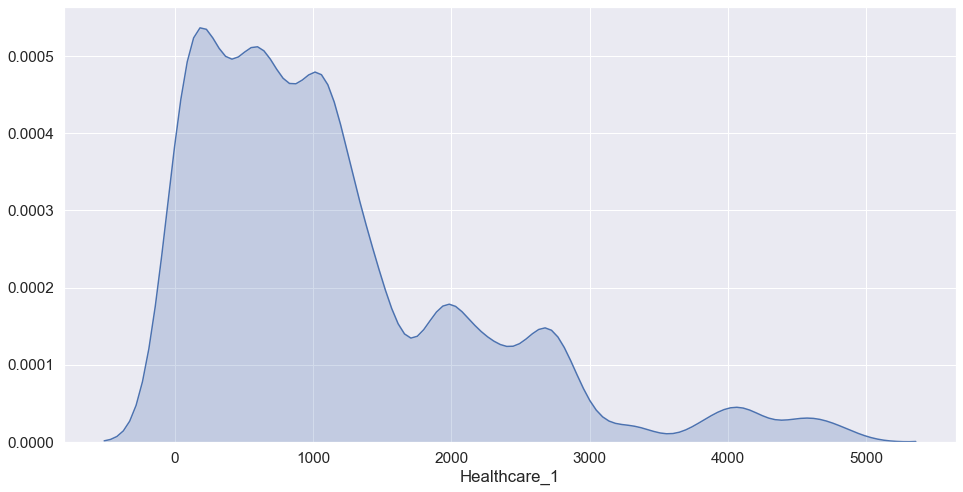

In [335]:
plt.figure(figsize = (16, 8))

sns.kdeplot(df_train['Healthcare_1'], shade=True, legend=False)
plt.xlabel('Healthcare_1')

Тут распределение значений больше похоже на нормальное, но есть неестественный скачек в районе 2-2.8 т. Но при этом считаю, что мы можем взять медиану для заполнения пропусков.

In [336]:
df_train.loc[df_train['Healthcare_1'].isnull(), 'Healthcare_1'] = df_train['Healthcare_1'].median()

## Обработка выбросов

In [337]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500
std,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000
75%,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


### Rooms

Прежде всего смущает максимальное значение. Хочется понять это выброс или это норма. Для проверки я решил посмотреть записи где количество комнат больше 5.

In [338]:
df_train[df_train['Rooms'] > 5]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
377,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,74,19083,2,900.0,5,15,317265.323792,1,1,1
1454,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,1,264,0,900.0,0,1,78364.616704,1,1,1
2170,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,66,10573,1,1322.0,3,8,229661.964416,1,1,1
8849,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,25,5648,1,30.0,2,4,172329.270863,1,1,1


Делаю вывод, что все эти наблюдения являются выбросами, так как слишком много комнат для их площади.

In [339]:
df_train.loc[df_train['Rooms'] > 5, 'Rooms'] = df_train['Rooms'].mode()[0]

Также кажется странным, что у нас есть квартиры, где количество комнат равно 0. Считаю, что эти наблюдения также нужно рассмотреть.

In [340]:
df_train[df_train['Rooms'] == 0]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
1397,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,11,3097,0,900.0,0,0,268394.744389,1,1,1
1981,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,9,1892,0,900.0,0,1,302211.260887,1,1,1
2269,27,0.0,41.790881,32.781260,0.0,13,0.0,1977,0.211401,9,1892,0,900.0,0,1,98129.976788,1,1,1
3911,28,0.0,49.483501,32.781260,0.0,16,0.0,2015,0.118537,30,6207,1,1183.0,1,0,217009.338463,1,1,1
4366,6,0.0,81.491446,32.781260,0.0,4,0.0,1977,0.243205,5,1564,0,540.0,0,0,212864.799112,1,1,1
4853,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,2,469,0,900.0,0,0,126596.941798,1,1,1
6149,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,43,8429,3,900.0,3,9,158998.110646,1,1,1
8834,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,9,1892,0,900.0,0,1,219281.918007,1,1,1


Все эти записи похожи на выбросы. Так как в результате нашего селекта значительно отличается площадь, то я считаю необходимым обновить значения по определенной логике. Логика обновления данных: Я буду брать моду для группы квартир выделеной по площади квартир.
Полученные данные можно разбить на 3 группы:
1. Менее 50
2. Больше 50, но меньше 90
3. Больше 90

In [341]:
df_train_rooms = df_train[(df_train['Rooms'] >= 1) & (df_train['Square'] < 50)]
df_train.loc[(df_train.Rooms == 0) & (df_train.Square < 50), 'Rooms'] = df_train_rooms['Rooms'].mode()[0]

df_train_rooms = df_train[(df_train['Rooms'] >= 1) & (df_train['Square'] >= 50) & (df_train['Square'] < 90)]
df_train.loc[(df_train.Rooms == 0) & (df_train['Square'] >= 50) & (df_train['Square'] < 90), 'Rooms'] = df_train_rooms['Rooms'].mode()[0]

df_train_rooms = df_train[(df_train['Rooms'] >= 1) & (df_train['Square'] > 90)]
df_train.loc[(df_train.Rooms == 0) & (df_train.Square > 90), 'Rooms'] = df_train_rooms['Rooms'].mode()[0]

### Square

Тут меня также смущет максимальное и минимальное значение.

In [342]:
df_train[(df_train.Square > 200) & (df_train.Rooms < 3)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
4262,9,2.0,604.705972,32.781260,1.0,17,18.0,1977,0.161532,25,5648,1,30.0,2,4,187717.242538,1,1,1
4690,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,26,3889,6,705.0,3,6,90470.430830,1,1,1
6977,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,22,6398,141,1046.0,3,23,133529.681562,1,1,1


При ознакомлении с результатами возникает ощущение, что выбросом является только запись с показателем Square == 604.705972, так как у только у неё другие признаки противоречат размеру площади квартиры.

По остальным двум записям вопросы также остаются из-за колличества комнат, но это возможно представить.

In [343]:
df_train_square = df_train[(df_train.Rooms == 2) & (df_train.LifeSquare < 40)]
df_train.loc[(df_train.Rooms == 2) & (df_train.Square > 600) & (df_train.LifeSquare < 40), 'Square'] = df_train_square['Square'].median()

Также кажется странным видеть квартиры у которых маленькая прощадь и жилая прощадь больше площади.

In [344]:
df_train[(df_train.Square < 21) & (df_train.Square < df_train.LifeSquare)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
212,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,43,8429,3,900.0,3,9,412511.088764,1,1,1
1608,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,5,1564,0,540.0,0,0,137597.601458,1,1,1
3166,150,1.0,17.046188,20.036232,8.0,7,12.0,1982,0.300323,52,10311,6,900.0,1,9,74222.110465,1,1,1
3280,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,9,1892,0,900.0,0,1,97560.720383,1,1,1
3413,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,16,3433,4,2643.0,4,5,369472.403061,1,1,1
4739,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,25,4756,16,2857.0,5,8,78388.806186,1,1,1
4900,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,9,1892,0,900.0,0,1,161379.067034,1,1,1
5617,57,3.0,16.547242,16.698571,8.0,5,5.0,1962,0.133215,49,11395,3,1406.0,3,4,77835.185808,1,1,0
6392,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,1,264,0,900.0,0,1,181434.825589,1,1,1
6945,62,2.0,17.414181,32.781260,1.0,4,20.0,1977,0.072158,2,629,1,900.0,0,0,180750.471749,1,1,0


In [345]:
df_train_square = df_train[df_train.Rooms == 2]
df_train.loc[(df_train.Square < 21) & (df_train.Square < df_train.LifeSquare) & (df_train.Rooms == 2), 'Square'] = df_train_square['Square'].median()
df_train.loc[(df_train.Square < 21) & (df_train.Square < df_train.LifeSquare) & (df_train.Rooms == 2), 'LifeSquare'] = df_train_square['LifeSquare'].median()

df_train_square = df_train[df_train.Rooms == 1]
df_train.loc[(df_train.Square < 21) & (df_train.Square < df_train.LifeSquare) & (df_train.Rooms == 1), 'Square'] = df_train_square['Square'].median()
df_train.loc[(df_train.Square < 21) & (df_train.Square < df_train.LifeSquare) & (df_train.Rooms == 1), 'LifeSquare'] = df_train_square['LifeSquare'].median()

df_train_square = df_train[df_train.Rooms == 3]
df_train.loc[(df_train.Square < 21) & (df_train.Square < df_train.LifeSquare) & (df_train.Rooms == 3), 'Square'] = df_train_square['Square'].median()
df_train.loc[(df_train.Square < 21) & (df_train.Square < df_train.LifeSquare) & (df_train.Rooms == 3), 'LifeSquare'] = df_train_square['LifeSquare'].median()

In [346]:
df_train[(df_train.Square < 10)]
df_train_square = df_train[df_train.Rooms == 1]
df_train.loc[(df_train.Square < 10) & (df_train.Rooms == 1), 'Square'] = df_train_square['Square'].median()
df_train.loc[(df_train.Square < 10) & (df_train.Rooms == 1), 'LifeSquare'] = df_train_square['LifeSquare'].median()

### LifeSquare

Text(0.5, 0, 'LifeSquare')

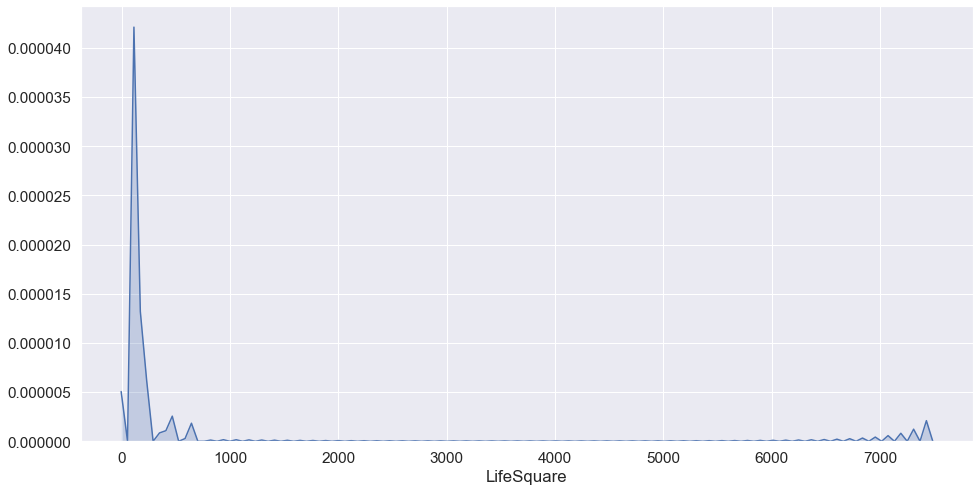

In [347]:
plt.figure(figsize = (16, 8))

sns.kdeplot(df_train['LifeSquare'], shade=True, legend=False)
plt.xlabel('LifeSquare')

Тут смущает резкий скачок по значения в конце графика.

In [348]:
df_train.loc[df_train.LifeSquare > np.percentile(df_train['LifeSquare'],99), 'LifeSquare'] = df_train['LifeSquare'].median()

### KitchenSquare

In [349]:
df_train.loc[df_train.KitchenSquare > np.percentile(df_train['KitchenSquare'], 99), 'KitchenSquare'] = df_train['KitchenSquare'].median()

### HouseFloor

Тут кажется странным видеть дома с 0 в качестве количества этажей.

In [350]:
df_train.loc[df_train.HouseFloor == 0, 'HouseFloor'] = df_train['HouseFloor'].median()

floor_outliers = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index

df_train.loc[floor_outliers, 'Floor'] = df_train.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

### HouseYear

In [351]:
df_train['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [352]:
df_train.loc[df_train.HouseYear > 2020, 'HouseYear'] = 2020

### DistrictId

In [353]:
df_train.loc[df_train.DistrictId == 0, 'DistrictId'] = df_train['DistrictId'].mode()[0]

### Ecology_1

0.007122    587
0.000000    537
0.243205    511
0.072158    486
0.075779    346
           ... 
0.386772      6
0.011320      3
0.394094      2
0.012522      1
0.014334      1
Name: Ecology_1, Length: 129, dtype: int64

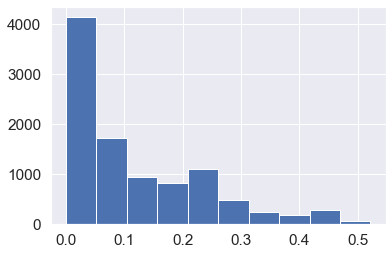

In [354]:
df_train['Ecology_1'].hist()
df_train['Ecology_1'].value_counts()

Так как таких значений достаточно много, можно сделать вывод, что тут выбросов нет.

### Social_1

2     688
1     654
25    557
5     528
30    465
23    434
6     377
22    367
53    355
34    311
33    252
46    245
31    243
43    238
9     213
36    209
21    207
37    205
24    205
52    201
0     201
35    200
47    177
74    176
39    159
27    151
28    144
4     141
11    138
42    129
26    127
16    123
19    118
66     99
17     96
49     95
18     92
32     87
41     83
50     79
29     70
38     64
8      62
15     51
20     50
14     46
10     24
13     22
12     18
7      15
3       9
Name: Social_1, dtype: int64

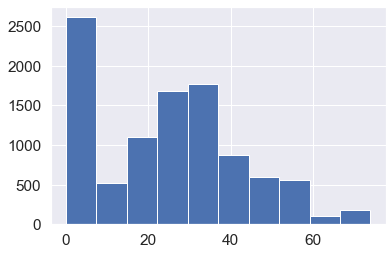

In [355]:
df_train['Social_1'].hist()
df_train['Social_1'].value_counts()

Также значений с 0 много и нельзя сделать вывод, что это выброс.

### Healthcare_1

900.0     4869
540.0      511
30.0       348
1046.0     245
750.0      163
          ... 
370.0       14
32.0        12
1815.0      10
35.0         2
0.0          1
Name: Healthcare_1, Length: 79, dtype: int64

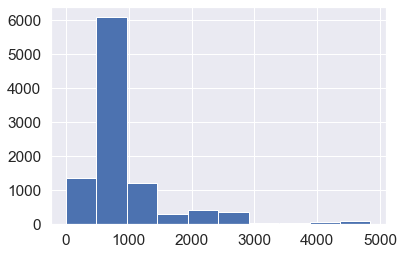

In [356]:
df_train['Healthcare_1'].hist()
df_train['Healthcare_1'].value_counts()

In [357]:
df_train.loc[df_train.Healthcare_1 == 0, 'Healthcare_1'] = df_train['Healthcare_1'].median()

### Shops_1

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

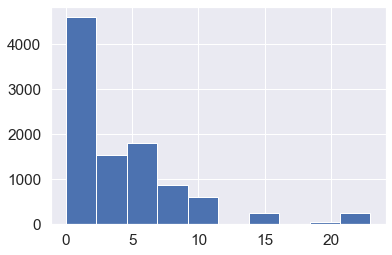

In [358]:
df_train['Shops_1'].hist()
df_train['Shops_1'].value_counts()

Также много минимальных значений и нельзя сказать, что эти данные являются выбросами.               

## Построение новых признаков

In [359]:
district_size = df_train['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

df_train = df_train.merge(district_size, on='DistrictId', how='left')
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,900.0,0,11,184966.930730,1,1,1,22
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063,1,1,1,87
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524,1,1,1,174
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217,1,1,1,179
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644,1,1,1,97


In [360]:
df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > 100).astype(int)

In [361]:
med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPriceByDistrict'})

df_train = df_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

## Работа с тестовой выборкой

In [362]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

### Приведение типов данных (df_test)

In [363]:
df_test['Ecology_2_bin'] = df_test['Ecology_2'].replace({'A':0, 'B':1})
df_test['Ecology_3_bin'] = df_test['Ecology_3'].replace({'A':0, 'B':1})
df_test['Shops_2_bin'] = df_test['Shops_2'].replace({'A':0, 'B':1})
df_test.drop(['Ecology_2' , 'Ecology_3', 'Shops_2'], axis=1, inplace=True)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,11,2748,1,NaN,0,0,1,1,1
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,6,1437,3,NaN,0,2,1,1,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,30,7538,87,4702.0,5,5,1,1,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,23,4583,3,NaN,3,3,1,1,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,2,629,1,NaN,0,0,1,1,0


### Обработка пропусков (df_test)


In [364]:
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_train['LifeSquare'].median()

In [365]:
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_train['Healthcare_1'].median()

### Обзор переменных (df_test)

In [366]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,35.455604,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.990400,0.970200,0.917600
std,4832.674037,44.179466,0.838594,19.092787,15.920269,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.097518,0.170052,0.275001
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,25.850152,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000,1.000000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.781260,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000,1.000000,1.000000
75%,12598.250000,77.000000,2.000000,66.285129,41.769526,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000,1.000000,1.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,1.000000,1.000000


### Обработка выбросов (df_test)

#### Rooms

In [367]:
df_test.loc[df_test['Rooms'] > 5, 'Rooms'] = df_train['Rooms'].mode()[0]

df_train_rooms = df_train[(df_train['Rooms'] >= 1) & (df_train['Square'] < 50)]
df_test.loc[(df_test.Rooms == 0) & (df_test.Square < 50), 'Rooms'] = df_train_rooms['Rooms'].mode()[0]

df_train_rooms = df_train[(df_train['Rooms'] >= 1) & (df_train['Square'] >= 50) & (df_train['Square'] < 90)]
df_test.loc[(df_test.Rooms == 0) & (df_test['Square'] >= 50) & (df_test['Square'] < 90), 'Rooms'] = df_train_rooms['Rooms'].mode()[0]

df_train_rooms = df_train[(df_train['Rooms'] >= 1) & (df_train['Square'] > 90)]
df_test.loc[(df_test.Rooms == 0) & (df_test.Square > 90), 'Rooms'] = df_train_rooms['Rooms'].mode()[0]

#### Square

In [368]:
df_train_square = df_train[(df_train.Rooms == 2) & (df_train.LifeSquare < 40)]
df_test.loc[(df_test.Rooms == 2) & (df_test.Square > 600) & (df_test.LifeSquare < 40), 'Square'] = df_train_square['Square'].median()


df_train_square = df_train[df_train.Rooms == 2]
df_test.loc[(df_test.Square < 21) & (df_test.Square < df_test.LifeSquare) & (df_test.Rooms == 2), 'Square'] = df_train_square['Square'].median()
df_test.loc[(df_test.Square < 21) & (df_test.Square < df_test.LifeSquare) & (df_test.Rooms == 2), 'LifeSquare'] = df_train_square['LifeSquare'].median()

df_train_square = df_train[df_train.Rooms == 1]
df_test.loc[(df_test.Square < 21) & (df_test.Square < df_test.LifeSquare) & (df_test.Rooms == 1), 'Square'] = df_train_square['Square'].median()
df_test.loc[(df_test.Square < 21) & (df_test.Square < df_test.LifeSquare) & (df_test.Rooms == 1), 'LifeSquare'] = df_train_square['LifeSquare'].median()

df_train_square = df_train[df_train.Rooms == 3]
df_test.loc[(df_test.Square < 21) & (df_test.Square < df_test.LifeSquare) & (df_test.Rooms == 3), 'Square'] = df_train_square['Square'].median()
df_test.loc[(df_test.Square < 21) & (df_test.Square < df_test.LifeSquare) & (df_test.Rooms == 3), 'LifeSquare'] = df_train_square['LifeSquare'].median()

df_train_square = df_train[df_train.Rooms == 1]
df_test.loc[(df_test.Square < 10) & (df_test.Rooms == 1), 'Square'] = df_train_square['Square'].median()
df_test.loc[(df_test.Square < 10) & (df_test.Rooms == 1), 'LifeSquare'] = df_train_square['LifeSquare'].median()

##### LifeSquare

In [369]:
df_test.loc[df_test.LifeSquare > np.percentile(df_test['LifeSquare'],99), 'LifeSquare'] = df_train['LifeSquare'].median()

#### KitchenSquare

In [370]:
df_test.loc[df_test.KitchenSquare > np.percentile(df_test['KitchenSquare'], 99), 'KitchenSquare'] = df_train['KitchenSquare'].median()

#### HouseFloor

In [371]:
df_test.loc[df_test.HouseFloor == 0, 'HouseFloor'] = df_train['HouseFloor'].median()

floor_outliers = df_test.loc[df_test['Floor'] > df_test['HouseFloor']].index

df_test.loc[floor_outliers, 'Floor'] = df_test.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

#### DistrictId

In [372]:
df_test.loc[df_test.DistrictId == 0, 'DistrictId'] = df_train['DistrictId'].mode()[0]

#### Healthcare_1

900.0     2409
540.0      257
30.0       163
1046.0     120
2300.0      78
          ... 
200.0        7
32.0         7
920.0        4
35.0         2
0.0          1
Name: Healthcare_1, Length: 79, dtype: int64

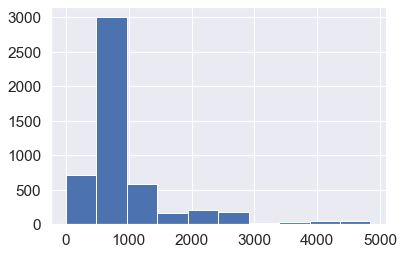

In [373]:
df_test['Healthcare_1'].hist()
df_test['Healthcare_1'].value_counts()

In [374]:
df_test.loc[df_test.Healthcare_1 == 0, 'Healthcare_1'] = df_train['Healthcare_1'].median()

### Построение новых признаков (df_test)

In [375]:
district_size = df_test['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

df_test = df_test.merge(district_size, on='DistrictId', how='left')
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,11,2748,1,900.0,0,0,1,1,1,91
1,15856,74,2.0,69.263183,32.781260,1.0,1,1.0,1977,0.075779,6,1437,3,900.0,0,2,1,1,1,61
2,5480,190,1.0,40.406590,15.948246,12.0,2,5.0,1909,0.000000,30,7538,87,4702.0,5,5,1,1,1,2
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,23,4583,3,900.0,3,3,1,1,1,49
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,2,629,1,900.0,0,0,1,1,0,410


In [376]:
df_test['IsDistrictLarge'] = (df_test['DistrictSize'] > 100).astype(int)

In [377]:
df_test = df_test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   int64  
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Social_1            5000 non-null   int64  
 11  Social_2            5000 non-null   int64  
 12  Social_3            5000 non-null   int64  
 13  Healthcare_1        5000 non-null   float64
 14  Helthcare_2         5000 non-null   int64  
 15  Shops_1             5000 non-null   int64  
 16  Ecolog

In [378]:
df_test.loc[df_test['MedPriceByDistrict'].isna(), 'MedPriceByDistrict'] =\
df_train['MedPriceByDistrict'].median()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   int64  
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Social_1            5000 non-null   int64  
 11  Social_2            5000 non-null   int64  
 12  Social_3            5000 non-null   int64  
 13  Healthcare_1        5000 non-null   float64
 14  Helthcare_2         5000 non-null   int64  
 15  Shops_1             5000 non-null   int64  
 16  Ecolog

 ## Анализ целевой переменной

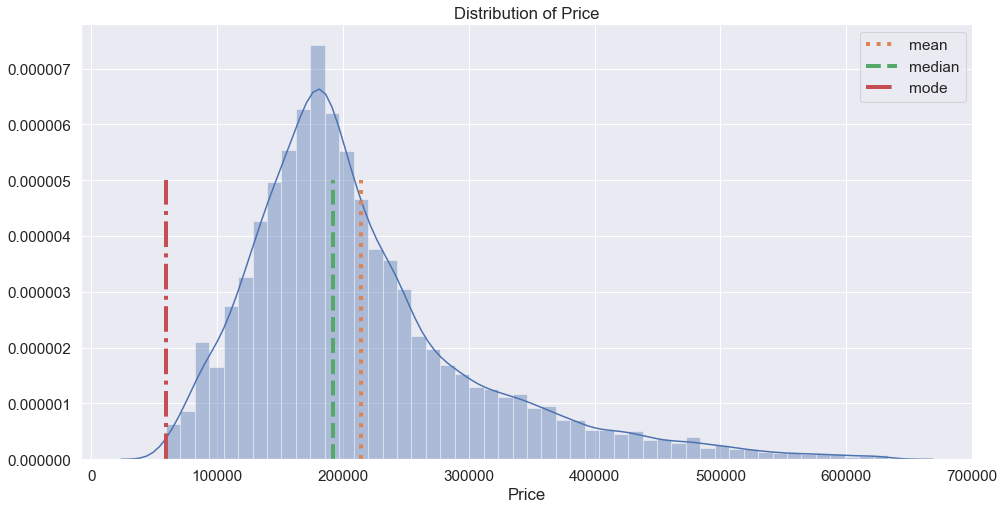

In [379]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()
target_mode = df_train['Price'].mode()[0]

plt.figure(figsize = (16, 8))

sns.distplot(df_train['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

### Оценка распредения целевой переменной в разрезе других признаков

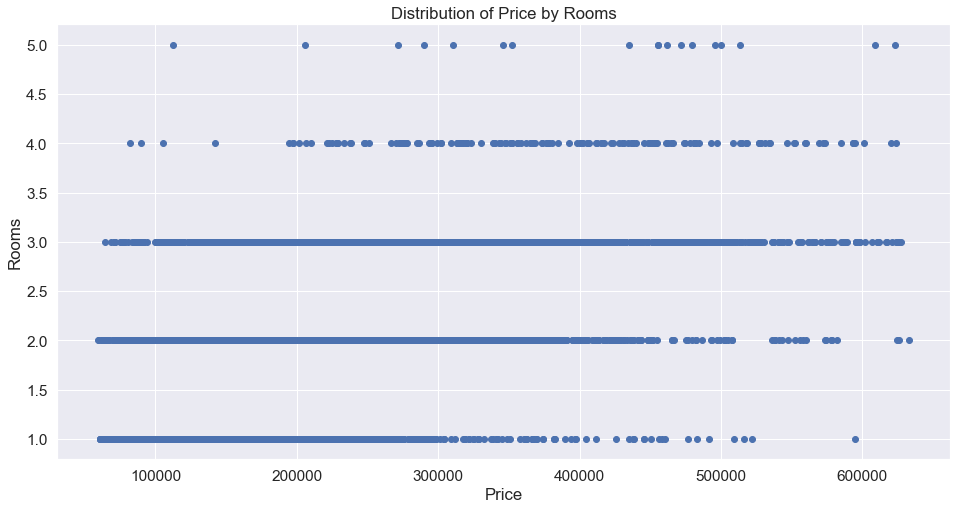

In [380]:
plt.figure(figsize=(16, 8))

plt.scatter(df_train['Price'], df_train['Rooms'])

plt.xlabel('Price')
plt.ylabel('Rooms')
plt.title('Distribution of Price by Rooms')
plt.show()

### Анализ признаков

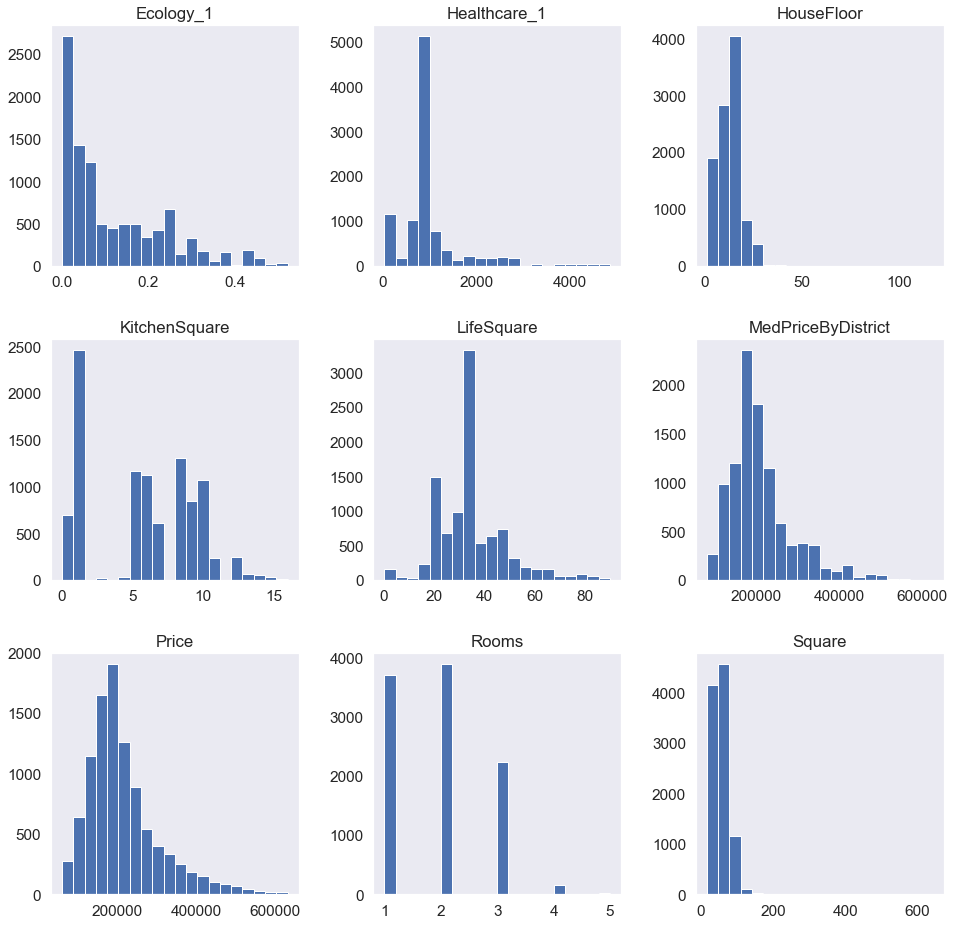

In [381]:
df_train_num_features = df_train.select_dtypes(include='float64')
df_train_num_features.hist(figsize=(16,16), bins=20, grid=False);

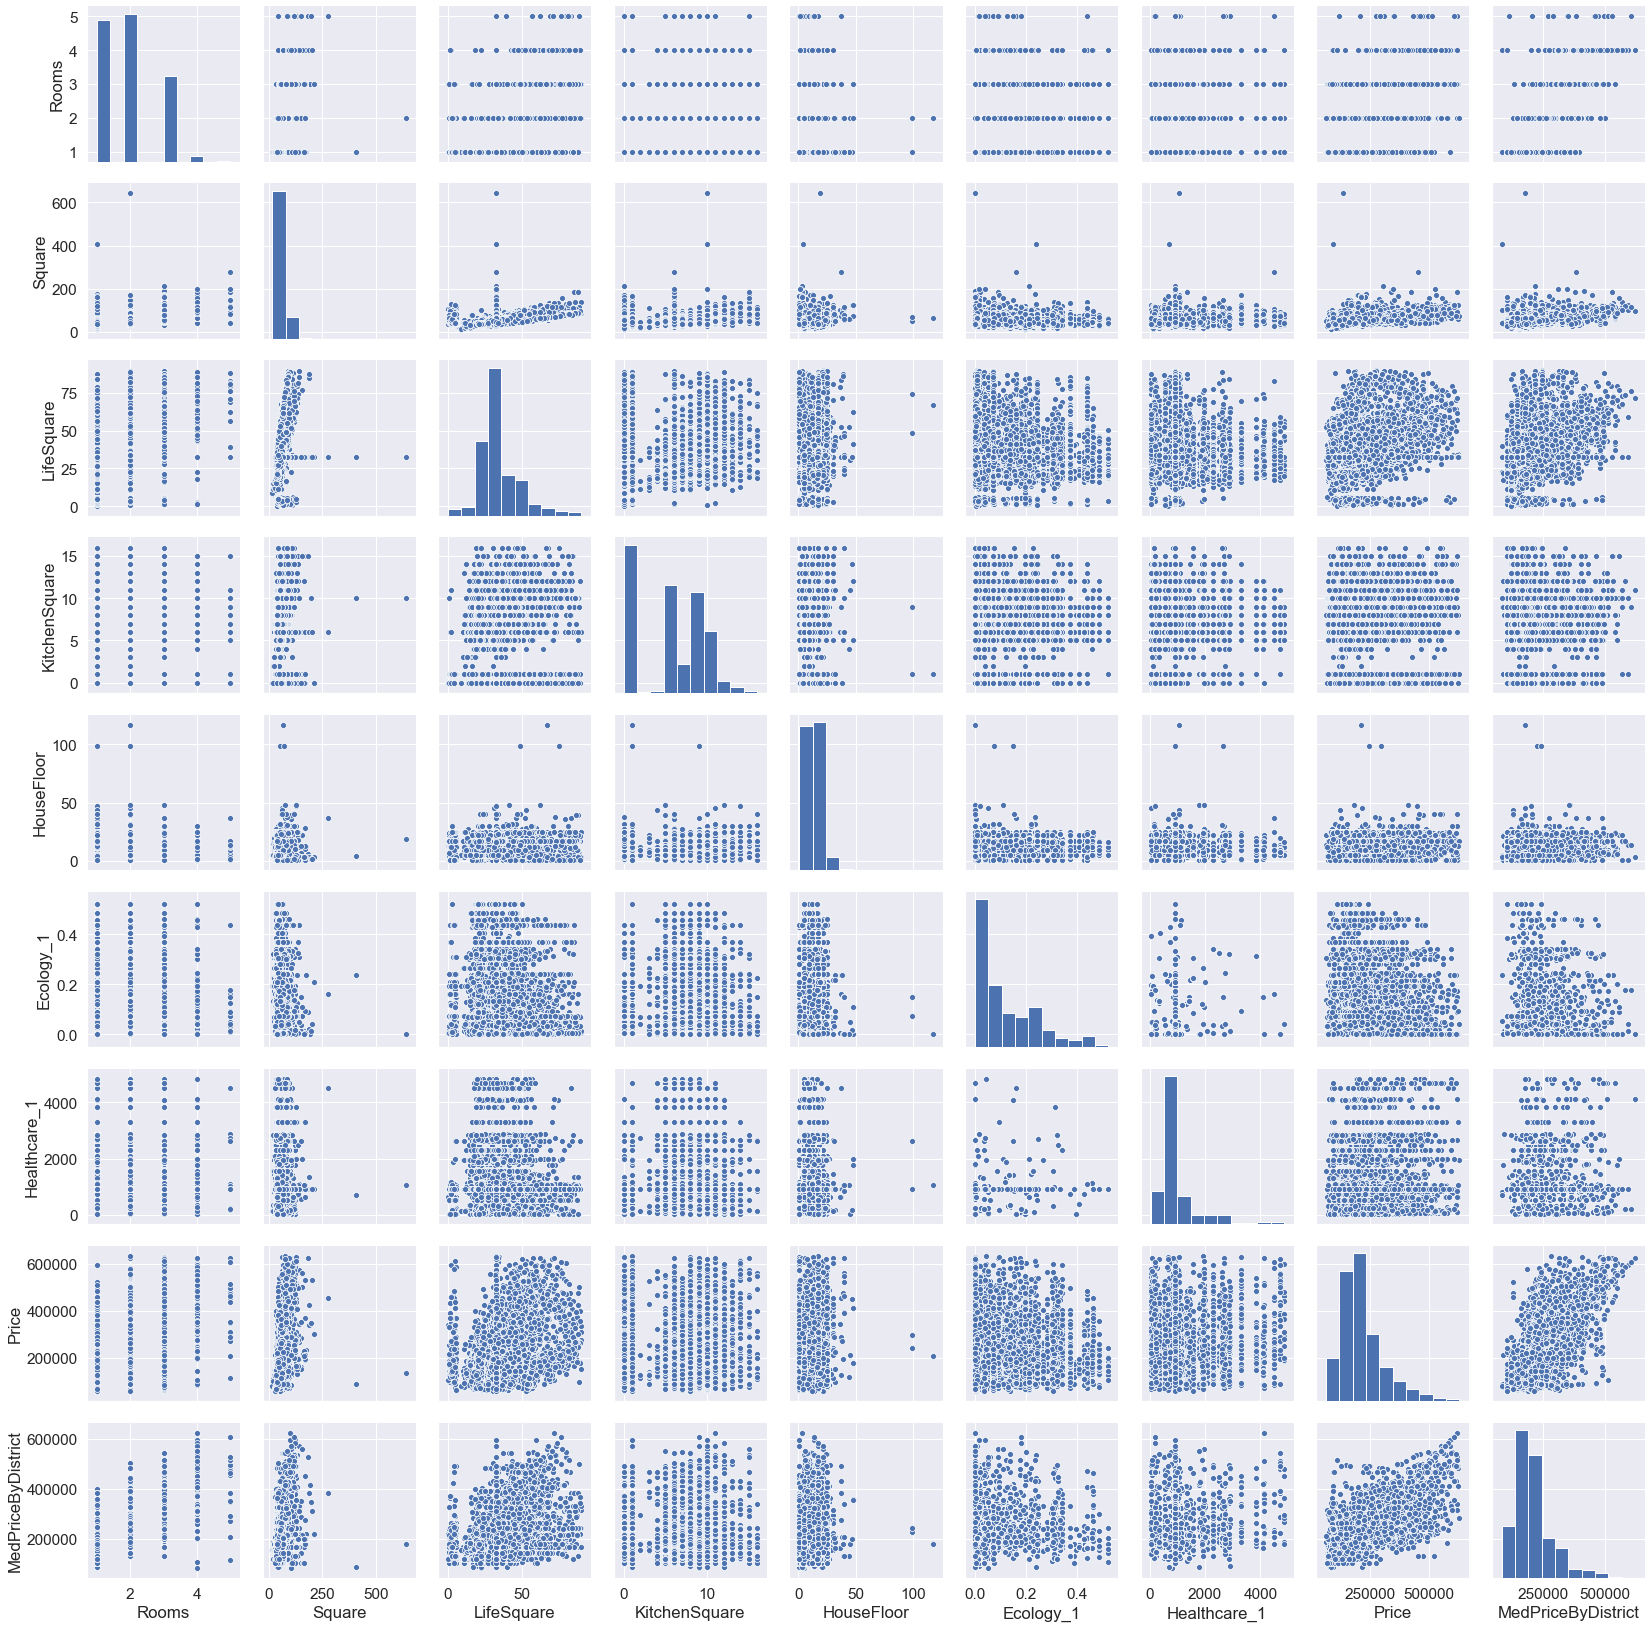

In [382]:
sns.pairplot(df_train_num_features);

### Матрица корреляций

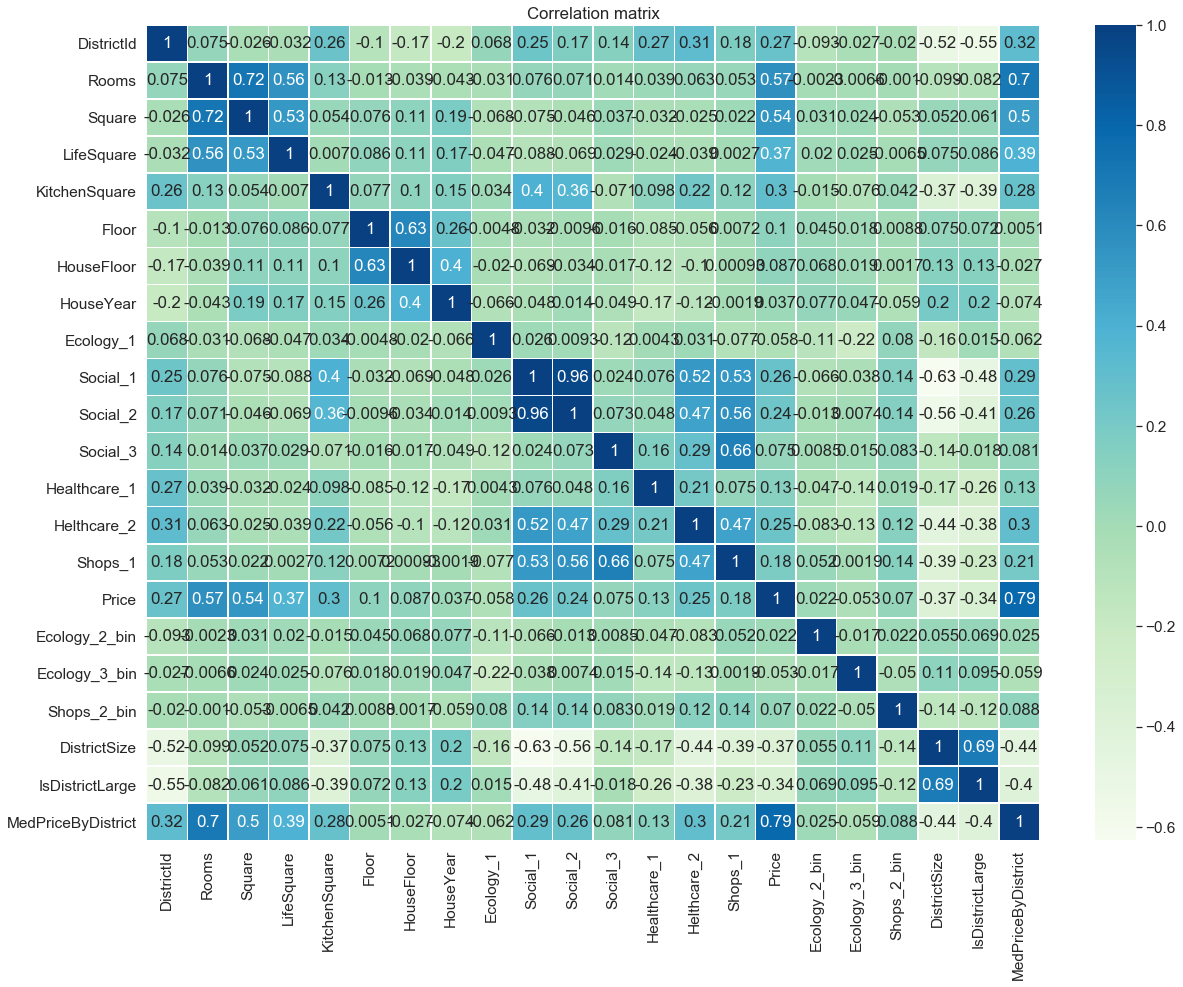

In [383]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков

In [384]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['DistrictSize', 'IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

### Cтандартизация

In [385]:
# Признаков с типо Float64
feature_names_for_stand = df_train[feature_names].select_dtypes(include='float64').columns.tolist()
scaler = StandardScaler()
stand_features = scaler.fit_transform(df_train[feature_names_for_stand])
df_train[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,35,0.137794,-0.412511,-0.375936,0.100184,7,-0.614468,1969,-0.250529,33,...,-0.169376,0,11,184966.930730,1,1,1,22,0,207786.135836
1,41,1.370296,0.461929,0.397786,0.629416,7,-0.614468,1978,-0.998053,46,...,-1.053436,1,16,300009.450063,1,1,1,87,0,300009.450063
2,53,0.137794,-0.562364,-0.393818,-1.487514,8,-0.148856,1968,-0.581588,34,...,-1.068170,1,3,220925.908524,1,1,1,174,1,263206.223152
3,58,0.137794,-0.147176,1.322882,0.894033,8,0.627163,1977,2.680470,23,...,0.077089,0,5,175616.227217,1,1,1,179,1,166809.665642
4,99,-1.094709,-0.824111,-0.789289,0.364800,11,-0.148856,1976,-0.894969,35,...,1.408536,2,4,150226.531644,1,1,1,97,0,158539.052715


In [386]:
# Признаки с типом int64
feature_names_for_stand = df_train[feature_names].select_dtypes(include='int64').columns.tolist()
scaler = StandardScaler()
stand_features = scaler.fit_transform(df_train[feature_names_for_stand])
df_train[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
df_train.head()

### Разбиение на train и test

In [387]:
X = df_train[feature_names + new_feature_names]
y = df_train[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение модели

**Обучение и оценка модели**

In [388]:
rf_model = RandomForestRegressor(n_estimators = 15, criterion='mse', random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=15, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

**Отложенная выборка**

Train R2:	0.954
Test R2:	0.742


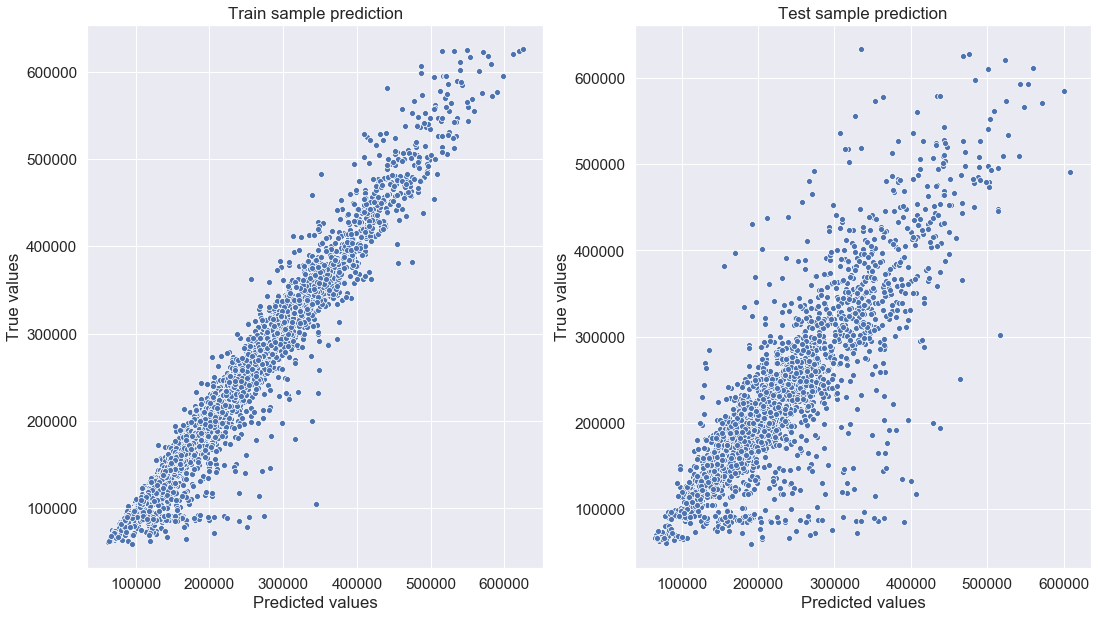

In [389]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Перекрёстная проверка**

In [390]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.74677943, 0.72109426, 0.71547791, 0.75819258, 0.73964432])

In [391]:
cv_score.mean()

0.7362376981034681

**Важность признаков**

In [392]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
20,MedPriceByDistrict,0.607999
2,Square,0.128333
3,LifeSquare,0.029118
6,HouseFloor,0.028726
7,HouseYear,0.026861
13,Social_3,0.024520
4,KitchenSquare,0.023221
18,DistrictSize,0.022781
5,Floor,0.020731
12,Social_2,0.014692


### Предсказываем цены

In [393]:
X_test = pd.get_dummies(df_test)
X_test.drop('Id', axis=1, inplace = True)
df_test['Price'] = rf_model.predict(X_test)

In [394]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,900.0,0,0,1,1,1,91,0,166809.665642,222607.601425
1,15856,74,2.0,69.263183,32.781260,1.0,1,1.0,1977,0.075779,...,900.0,0,2,1,1,1,61,0,243031.695525,365656.453933
2,5480,190,1.0,40.406590,15.948246,12.0,2,5.0,1909,0.000000,...,4702.0,5,5,1,1,1,2,0,195474.299127,347711.362363
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,900.0,3,3,1,1,1,49,0,222227.584211,366236.810218
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,900.0,0,0,1,1,0,410,1,118766.902694,448060.059630


In [395]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   int64  
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Social_1            5000 non-null   int64  
 11  Social_2            5000 non-null   int64  
 12  Social_3            5000 non-null   int64  
 13  Healthcare_1        5000 non-null   float64
 14  Helthcare_2         5000 non-null   int64  
 15  Shops_1             5000 non-null   int64  
 16  Ecolog

#### Выгрузка данных

In [396]:
df_test.loc[:, ['Id', 'Price']].to_csv('MKuzmin_prediction.csv', index=False)